# Практикум 3: Побудова композитних індикаторів

## Оцінка інноваційної активності країн світу

**Виконали:** Чижов Андрій, Гермаш Аліна, Забрудська Поліна

**Група:** КІ-33

---

## 1. Огляд рішень

Для оцінки інноваційної активності країн використовують міжнародні рейтинги:

| Індекс | Опис |
|--------|------|
| **Global Innovation Index (GII)** | Щорічний рейтинг, що оцінює інноваційний потенціал та результати інновацій у країнах світу |
| **Bloomberg Innovation Index** | Ранжує країни за інноваційними показниками: R&D, продуктивність, патенти |
| **European Innovation Scoreboard (EIS)** | Оцінює країни ЄС за різними аспектами інноваційної діяльності |

**Основні методи оцінки:**
- Використання агрегованих показників (зважена сума)
- Стандартизація показників (z-score) для об'єднання різнорідних даних
- Створення композитних індикаторів
- Аналіз головних компонент (PCA)

## 2. Концептуальна модель та підбір індикаторів

**Концептуальна модель:**

$$\text{Інноваційна активність} = f(\text{Ресурси} + \text{Виходи} + \text{Екосистема})$$

**Підібрані індикатори (6 показників):**

| Група | Показник | Скорочення | Джерело |
|-------|----------|------------|----------|
| **Ресурси** | R&D витрати (% ВВП) | R&D_pct_GDP | World Bank |
| **Ресурси** | Частка STEM-випускників (%) | STEM_pct | UNESCO |
| **Виходи** | Наукові публікації на 1 млн населення | Publications | Our World in Data |
| **Виходи** | Патенти на 1 млн населення | Patents_per_million | Our World in Data |
| **Екосистема** | Рання підприємницька активність TEA (%) | TEA_pct | GEM |
| **Екосистема** | Щільність нових бізнесів (на 1000 осіб 15-64) | New_Business_Density | World Bank |

**Розподіл ваг:**
- Ресурси: 30% (по 15% кожен показник)
- Виходи: 40% (по 20% кожен показник)
- Екосистема: 30% (по 15% кожен показник)

## 3. Пул об'єктів, заповнення пропусків та багатовимірний статистичний аналіз

**Параметри дослідження:**
- Пул об'єктів: **75 країн**
- Часовий період: **2005-2022 роки (18 років)**
- Загальна кількість спостережень: 75 × 18 = 1350

### 3.1 Завантаження бібліотек та даних

In [1]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)

print("Бібліотеки завантажено успішно")

Бібліотеки завантажено успішно


In [2]:
# Завантаження даних
df = pd.read_csv("raw_data_75.csv")

print("Інформація про датасет:")
print(f"  Розмір: {df.shape[0]} рядків × {df.shape[1]} стовпців")
print(f"  Кількість країн: {df['Country'].nunique()}")
print(f"  Часовий період: {df['Year'].min()} - {df['Year'].max()} ({df['Year'].max() - df['Year'].min() + 1} років)")

print("\nПерші 5 рядків датасету:")
df.head()

Інформація про датасет:
  Розмір: 1350 рядків × 9 стовпців
  Кількість країн: 75
  Часовий період: 2005 - 2022 (18 років)

Перші 5 рядків датасету:


,Country,Code,Year,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
0,Algeria,DZA,2005,27.086,0.064,NaN,1.782,NaN,NaN
1,Algeria,DZA,2006,37.871,NaN,NaN,1.725,NaN,0.398
2,Algeria,DZA,2007,40.842,NaN,25.383,2.457,NaN,0.348
3,Algeria,DZA,2008,50.232,NaN,NaN,NaN,NaN,0.477
4,Algeria,DZA,2009,59.606,NaN,24.012,NaN,16.68,0.448


In [3]:
# Загальна інформація про дані
print("Структура даних:")
df.info()

Структура даних:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               1350 non-null   object 
 1   Code                  1350 non-null   object 
 2   Year                  1350 non-null   int64  
 3   Publications          1350 non-null   float64
 4   R&D_pct_GDP           1172 non-null   float64
 5   STEM_pct              904 non-null    float64
 6   Patents_per_million   1195 non-null   float64
 7   TEA_pct               738 non-null    float64
 8   New_Business_Density  1118 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 95.1+ KB


### 3.2 Заповнення пропусків

In [4]:
# Визначення числових колонок для аналізу
num_cols = ['Publications', 'R&D_pct_GDP', 'STEM_pct', 
            'Patents_per_million', 'TEA_pct', 'New_Business_Density']

# Аналіз пропусків
missing_info = pd.DataFrame({
    'Кількість пропусків': df[num_cols].isnull().sum(),
    'Відсоток (%)': (df[num_cols].isnull().sum() / len(df) * 100).round(2)
})

print("Аналіз пропусків у даних:")
print(missing_info)
print(f"\nЗагальна кількість пропусків: {df[num_cols].isnull().sum().sum()}")

Аналіз пропусків у даних:
                      Кількість пропусків  Відсоток (%)
Publications                            0          0.00
R&D_pct_GDP                           178         13.19
STEM_pct                              446         33.04
Patents_per_million                   155         11.48
TEA_pct                               612         45.33
New_Business_Density                  232         17.19

Загальна кількість пропусків: 1623


In [5]:
# Заповнення пропусків методом лінійної інтерполяції
df_filled = df.copy()

# Перетворення на числові типи
df_filled[num_cols] = df_filled[num_cols].apply(pd.to_numeric, errors='coerce')

# Лінійна інтерполяція по групах країн (Code)
df_filled[num_cols] = df_filled.groupby('Code')[num_cols].transform(
    lambda g: g.interpolate(method='linear', limit_direction='both')
)

# Заповнення залишкових пропусків на початку/кінці груп
df_filled[num_cols] = df_filled[num_cols].ffill().bfill()

print("Результати заповнення:")
print("  Пропуски після обробки:")
print(df_filled[num_cols].isnull().sum())
print("\n✓ Всі пропуски успішно заповнено")

# Збереження оброблених даних
import os
os.makedirs('raw_data', exist_ok=True)
os.makedirs('processed_data', exist_ok=True)
df.to_csv('raw_data/raw_data_75.csv', index=False)
df_filled.to_csv('processed_data/raw_data_filled.csv', index=False)
print("\n Файли збережено:")
print("   raw_data/raw_data_75.csv")
print("   processed_data/raw_data_filled.csv")

Результати заповнення:
  Пропуски після обробки:
Publications            0
R&D_pct_GDP             0
STEM_pct                0
Patents_per_million     0
TEA_pct                 0
New_Business_Density    0
dtype: int64

✓ Всі пропуски успішно заповнено

 Файли збережено:
   raw_data/raw_data_75.csv
   processed_data/raw_data_filled.csv


### 3.3 Багатовимірний статистичний аналіз

In [6]:
# Описова статистика
print("Описова статистика показників інноваційної активності:")
print("\n" + "="*80)
df_filled[num_cols].describe().round(2)

Описова статистика показників інноваційної активності:



,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
count,1350.00,1350.00,1350.00,1350.00,1350.00,1350.00
mean,762.35,1.16,23.27,162.93,11.43,4.90
std,720.35,1.03,6.15,439.94,6.03,5.16
min,0.00,0.01,7.55,0.05,1.56,0.02
25%,119.40,0.34,19.09,12.10,6.67,1.21
50%,533.13,0.76,23.00,39.67,9.99,3.13
75%,1362.36,1.81,26.76,146.79,14.62,7.04
max,2881.05,6.02,45.46,3597.58,40.08,38.20


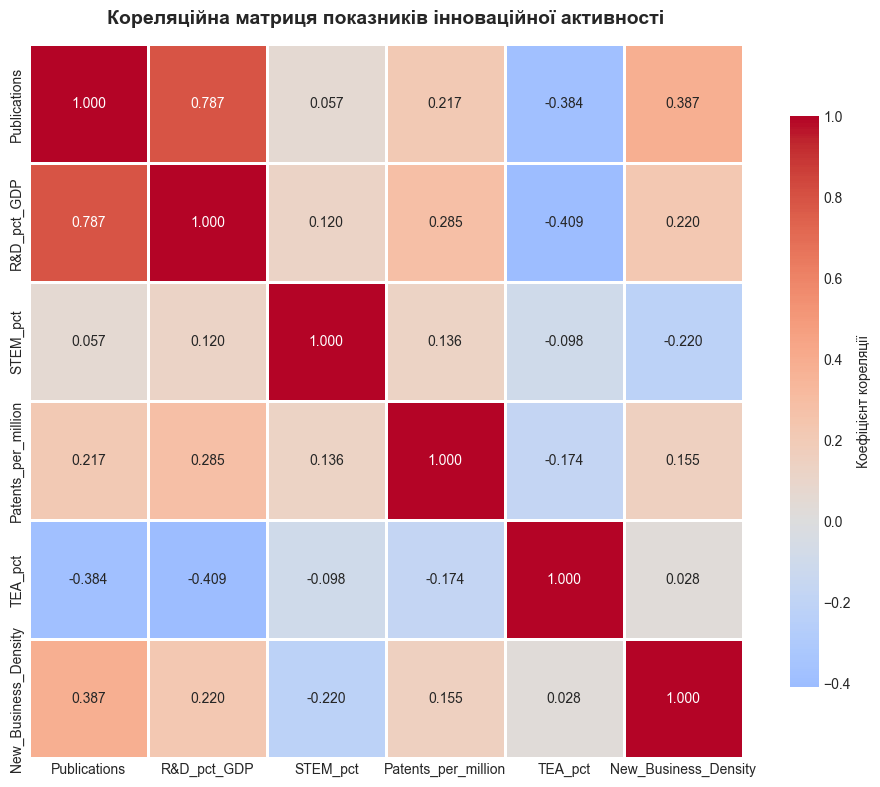


Кореляційна матриця:
                      Publications  R&D_pct_GDP  STEM_pct  \
Publications                 1.000        0.787     0.057   
R&D_pct_GDP                  0.787        1.000     0.120   
STEM_pct                     0.057        0.120     1.000   
Patents_per_million          0.217        0.285     0.136   
TEA_pct                     -0.384       -0.409    -0.098   
New_Business_Density         0.387        0.220    -0.220   

                      Patents_per_million  TEA_pct  New_Business_Density  
Publications                        0.217   -0.384                 0.387  
R&D_pct_GDP                         0.285   -0.409                 0.220  
STEM_pct                            0.136   -0.098                -0.220  
Patents_per_million                 1.000   -0.174                 0.155  
TEA_pct                            -0.174    1.000                 0.028  
New_Business_Density                0.155    0.028                 1.000  


In [7]:
# Кореляційний аналіз
corr_matrix = df_filled[num_cols].corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8, "label": "Коефіцієнт кореляції"})
plt.title('Кореляційна матриця показників інноваційної активності', 
          fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nКореляційна матриця:")
print(corr_matrix.round(3))

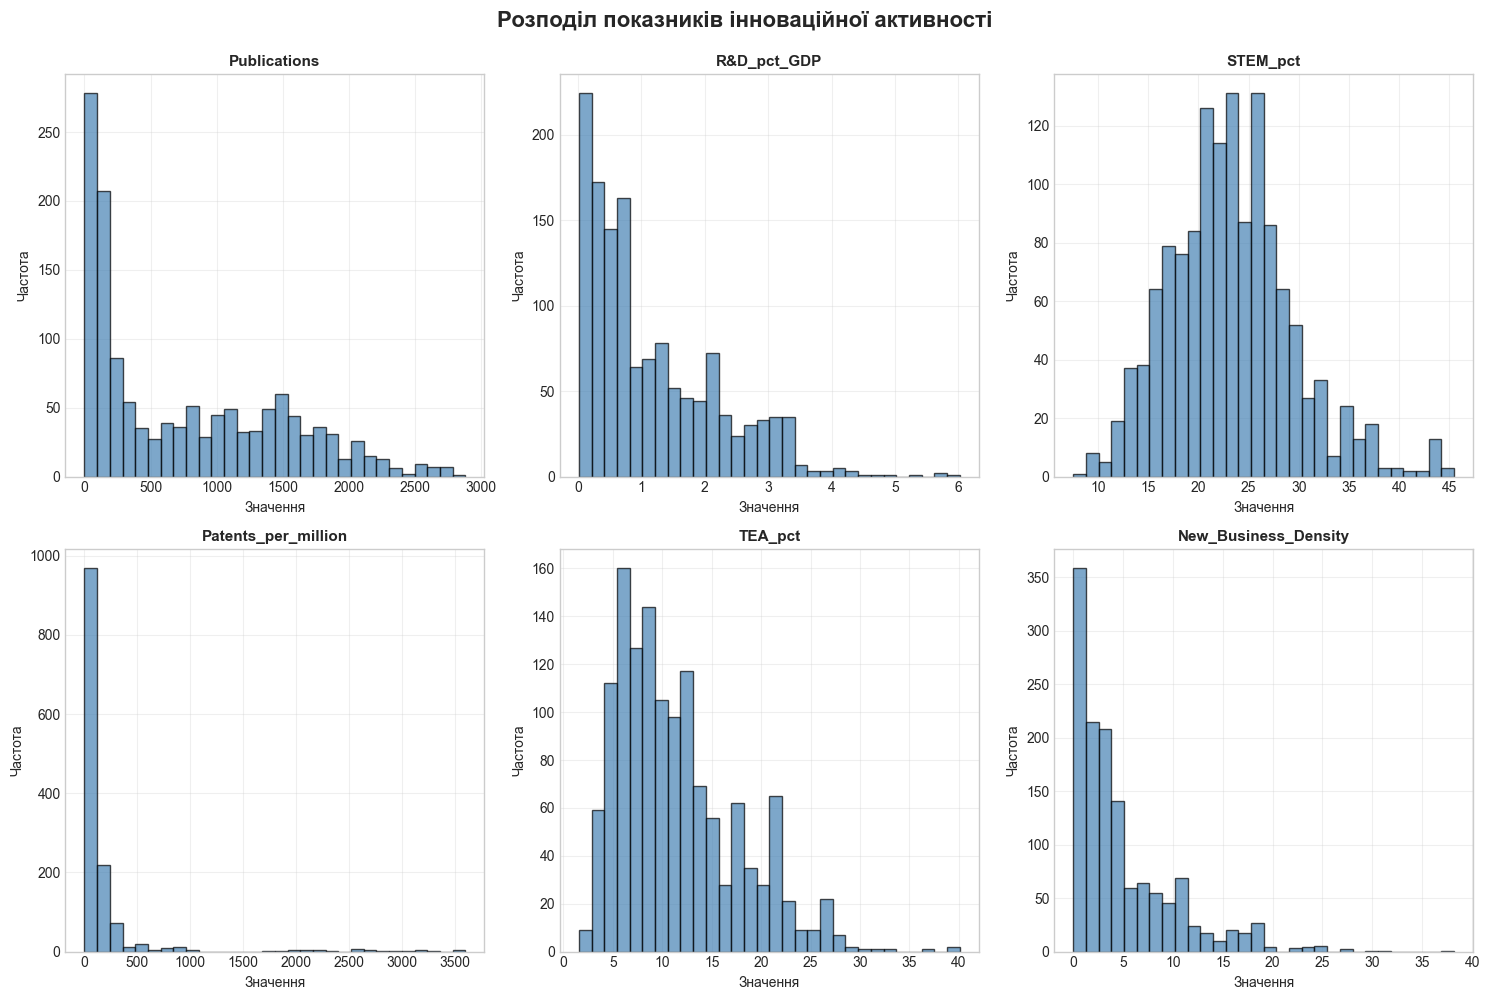

In [8]:
# Аналіз розподілів за допомогою гістограм
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    axes[idx].hist(df_filled[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Значення', fontsize=10)
    axes[idx].set_ylabel('Частота', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Розподіл показників інноваційної активності', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

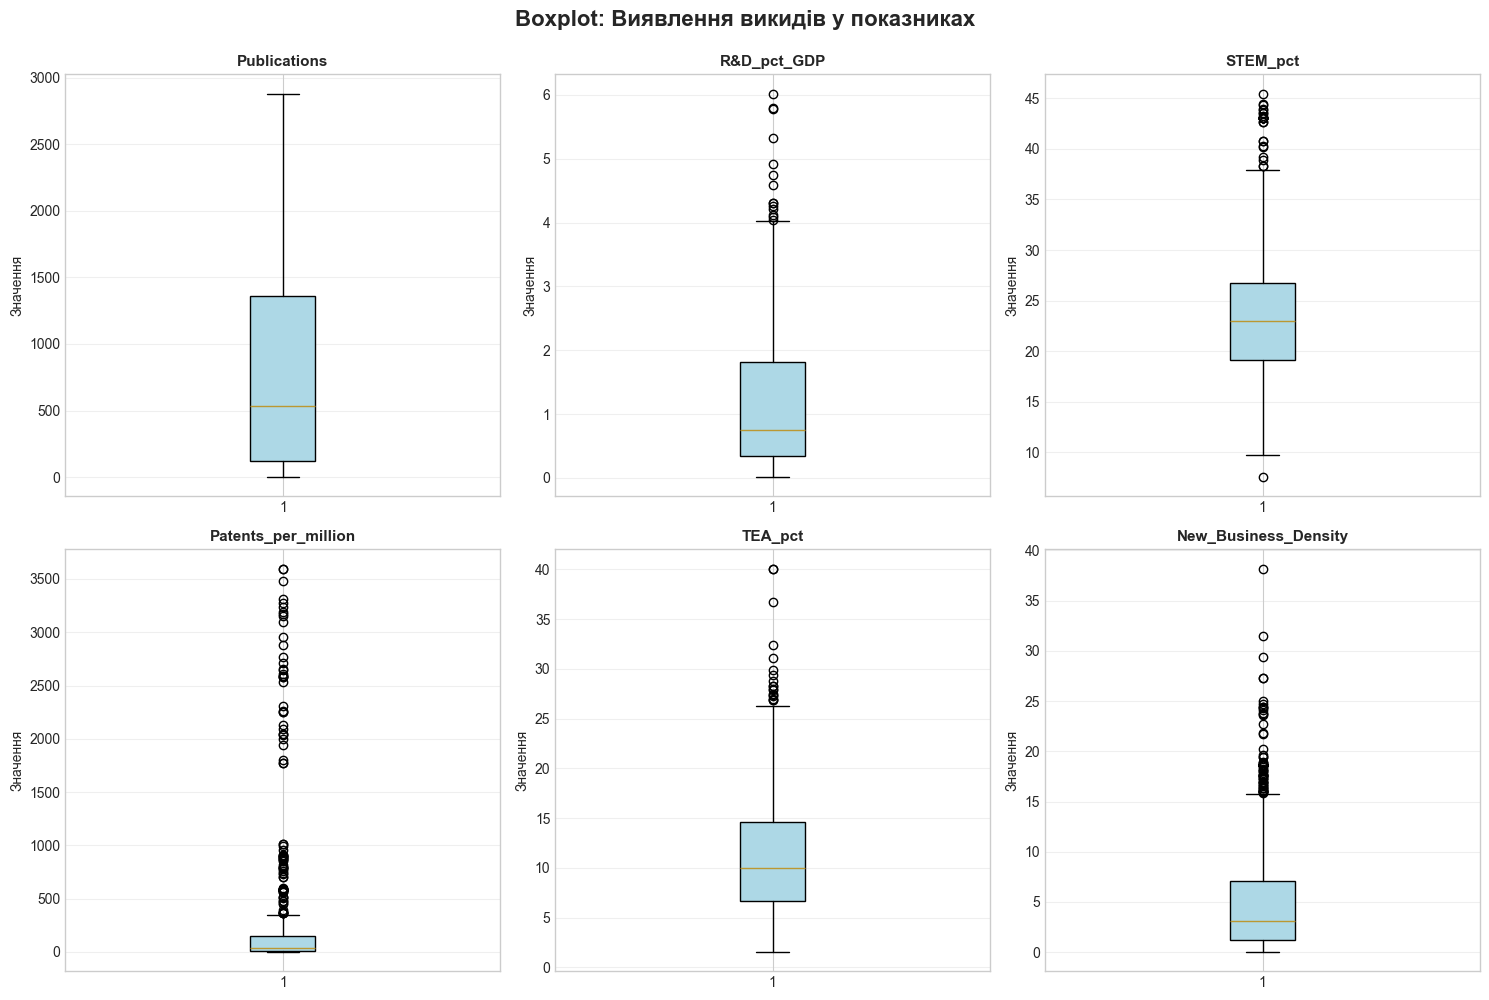

In [9]:
# Boxplot для виявлення викидів
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    bp = axes[idx].boxplot(df_filled[col].dropna(), patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Значення', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Boxplot: Виявлення викидів у показниках', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

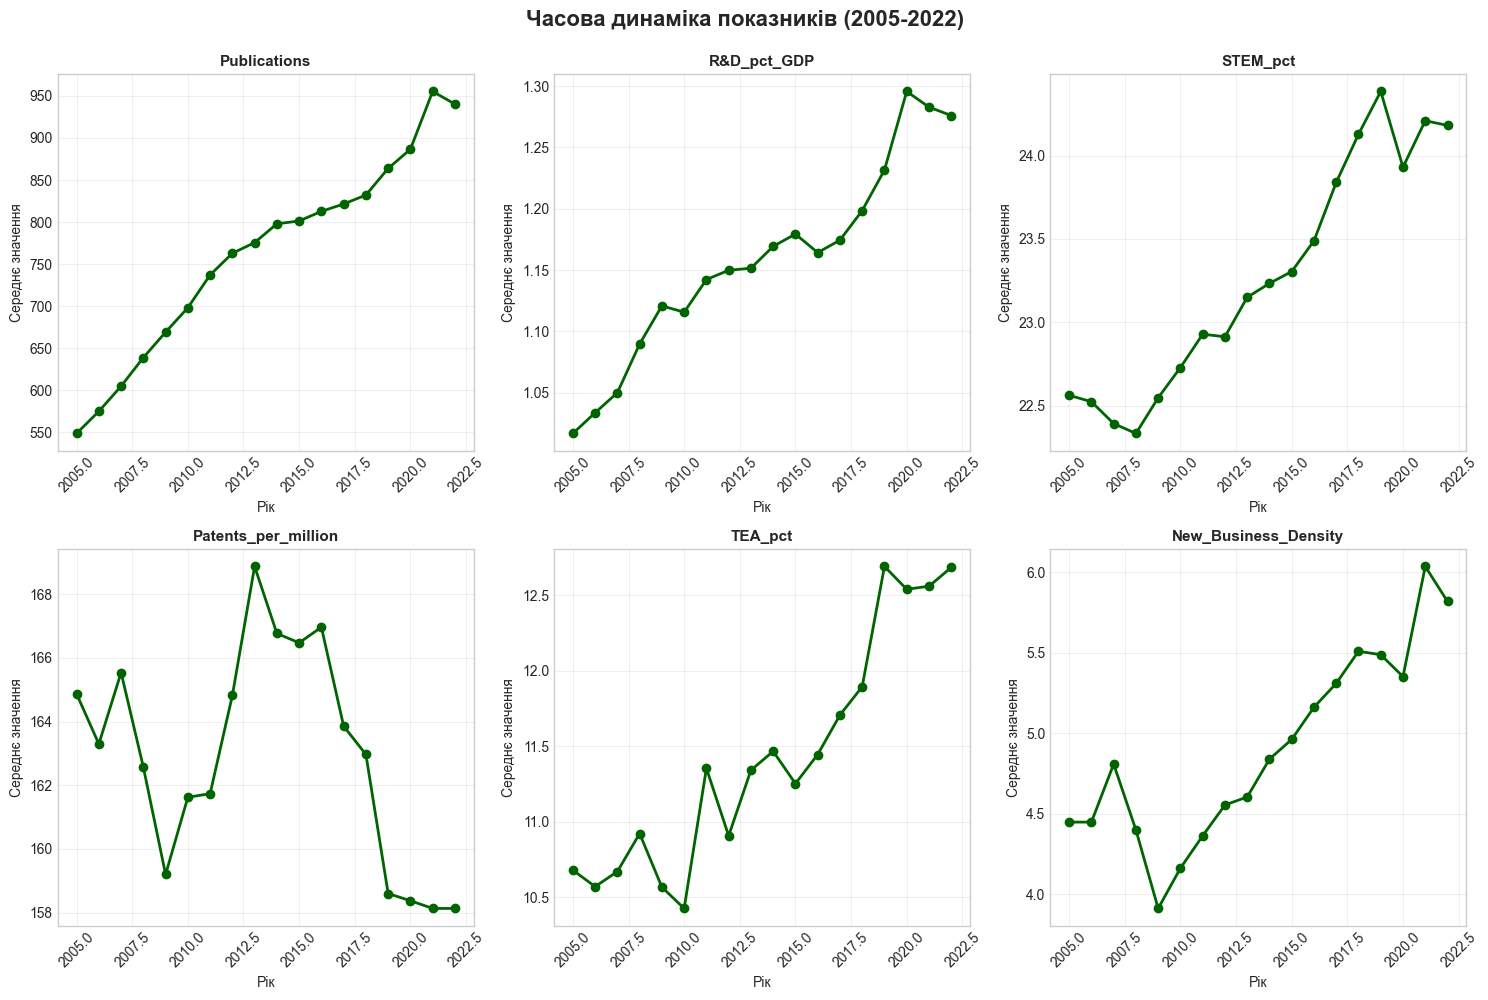

Висновок з часового аналізу:
  Проаналізовано динаміку змін показників інноваційної активності
  за 18-річний період для виявлення трендів та закономірностей.


In [10]:
# Часовий аналіз - динаміка середніх значень по роках
yearly_avg = df_filled.groupby('Year')[num_cols].mean()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    axes[idx].plot(yearly_avg.index, yearly_avg[col], marker='o', 
                   linewidth=2, markersize=6, color='darkgreen')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Рік', fontsize=10)
    axes[idx].set_ylabel('Середнє значення', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Часова динаміка показників (2005-2022)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Висновок з часового аналізу:")
print("  Проаналізовано динаміку змін показників інноваційної активності")
print("  за 18-річний період для виявлення трендів та закономірностей.")

## 4. Нормалізація даних та побудова моделі

### 4.1 Нормалізація даних методом Z-score

In [11]:
# Стандартизація (Z-score нормалізація)
scaler = StandardScaler()
df_normalized = df_filled.copy()
df_normalized[num_cols] = scaler.fit_transform(df_filled[num_cols])

print("Нормалізація даних методом Z-score:")
print("\nФормула: z = (x - μ) / σ")
print("  де μ - середнє значення, σ - стандартне відхилення\n")

print("Перші 10 рядків нормалізованих даних:")
display(df_normalized[['Country', 'Year'] + num_cols].head(10))

print("\nПеревірка нормалізації:")
print("Середні значення (повинні бути ≈ 0):")
print(df_normalized[num_cols].mean().round(6))
print("\nСтандартні відхилення (повинні бути ≈ 1):")
print(df_normalized[num_cols].std().round(3))
print("\n Нормалізація виконана коректно")

Нормалізація даних методом Z-score:

Формула: z = (x - μ) / σ
  де μ - середнє значення, σ - стандартне відхилення

Перші 10 рядків нормалізованих даних:


,Country,Year,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
0,Algeria,2005,-1.021,-1.064,0.344,-0.366,0.872,-0.873
1,Algeria,2006,-1.006,-1.030,0.344,-0.367,0.872,-0.873
2,Algeria,2007,-1.002,-0.997,0.344,-0.365,0.872,-0.882
3,Algeria,2008,-0.989,-0.963,0.233,-0.365,0.872,-0.857
4,Algeria,2009,-0.976,-0.929,0.121,-0.365,0.872,-0.863
5,Algeria,2010,-0.978,-0.896,0.873,-0.366,0.256,-0.873
6,Algeria,2011,-0.968,-0.862,0.384,-0.365,-0.359,-0.853
7,Algeria,2012,-0.948,-0.829,0.612,-0.363,-0.444,-0.842
8,Algeria,2013,-0.936,-0.795,0.839,-0.364,-1.084,-0.841
9,Algeria,2014,-0.931,-0.761,1.067,-0.365,-1.084,-0.832



Перевірка нормалізації:
Середні значення (повинні бути ≈ 0):
Publications            0.0
R&D_pct_GDP            -0.0
STEM_pct                0.0
Patents_per_million    -0.0
TEA_pct                 0.0
New_Business_Density    0.0
dtype: float64

Стандартні відхилення (повинні бути ≈ 1):
Publications            1.0
R&D_pct_GDP             1.0
STEM_pct                1.0
Patents_per_million     1.0
TEA_pct                 1.0
New_Business_Density    1.0
dtype: float64

 Нормалізація виконана коректно


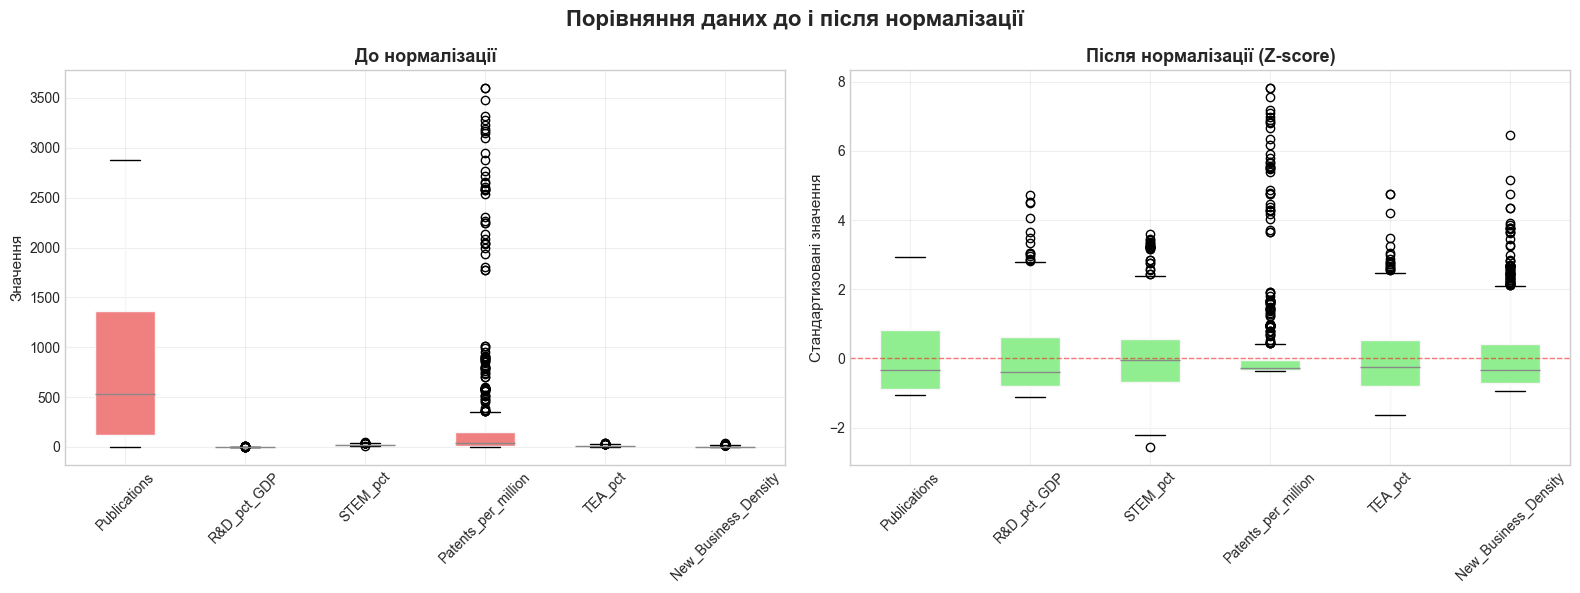

In [12]:
# Порівняння до та після нормалізації
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# До нормалізації
bp1 = df_filled[num_cols].boxplot(ax=ax1, patch_artist=True, return_type='dict')
for patch in bp1['boxes']:
    patch.set_facecolor('lightcoral')
ax1.set_title('До нормалізації', fontweight='bold', fontsize=13)
ax1.set_ylabel('Значення', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Після нормалізації
bp2 = df_normalized[num_cols].boxplot(ax=ax2, patch_artist=True, return_type='dict')
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')
ax2.set_title('Після нормалізації (Z-score)', fontweight='bold', fontsize=13)
ax2.set_ylabel('Стандартизовані значення', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.suptitle('Порівняння даних до і після нормалізації', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Побудова композитного індексу інноваційної активності

In [13]:
# Зважений композитний індекс
# Відповідно до концептуальної моделі: Ресурси (30%), Виходи (40%), Екосистема (30%)

weights = {
    'R&D_pct_GDP': 0.15,         # Ресурси
    'STEM_pct': 0.15,            # Ресурси
    'Publications': 0.20,        # Виходи
    'Patents_per_million': 0.20, # Виходи
    'TEA_pct': 0.15,             # Екосистема
    'New_Business_Density': 0.15 # Екосистема
}

print("Система ваг композитного індексу:")
print("\nГрупа показників та їх ваги:")
print("  Ресурси (30%):")
print("    - R&D_pct_GDP: 15%")
print("    - STEM_pct: 15%")
print("  Виходи (40%):")
print("    - Publications: 20%")
print("    - Patents_per_million: 20%")
print("  Екосистема (30%):")
print("    - TEA_pct: 15%")
print("    - New_Business_Density: 15%")
print(f"\nСума ваг: {sum(weights.values())*100:.0f}%")

# Обчислення композитного індексу
df_normalized['Innovation_Index'] = sum(
    df_normalized[col] * weight for col, weight in weights.items()
)

# Масштабування до діапазону 0-100
min_val = df_normalized['Innovation_Index'].min()
max_val = df_normalized['Innovation_Index'].max()
df_normalized['Innovation_Index_100'] = (
    (df_normalized['Innovation_Index'] - min_val) / (max_val - min_val) * 100
)

print("\n" + "="*80)
print("Статистика композитного індексу інноваційної активності:")
print("="*80)
print(df_normalized['Innovation_Index_100'].describe().round(2))
print("\n Композитний індекс успішно побудовано")

Система ваг композитного індексу:

Група показників та їх ваги:
  Ресурси (30%):
    - R&D_pct_GDP: 15%
    - STEM_pct: 15%
  Виходи (40%):
    - Publications: 20%
    - Patents_per_million: 20%
  Екосистема (30%):
    - TEA_pct: 15%
    - New_Business_Density: 15%

Сума ваг: 100%

Статистика композитного індексу інноваційної активності:
count    1350.00
mean       29.20
std        16.82
min         0.00
25%        16.57
50%        25.70
75%        39.99
max       100.00
Name: Innovation_Index_100, dtype: float64

 Композитний індекс успішно побудовано


### 4.3 Рейтинг країн за індексом інноваційної активності

In [14]:
# Обчислення середнього індексу по країнах за весь період
country_avg = df_normalized.groupby('Country')['Innovation_Index_100'].mean().sort_values(ascending=False)

print("РЕЙТИНГ КРАЇН ЗА ІНДЕКСОМ ІННОВАЦІЙНОЇ АКТИВНОСТІ")
print("(середнє значення за 2005-2022 роки)")
print("\n" + "="*60)
print("\nТоп-20 країн:")
print("="*60)

for i, (country, score) in enumerate(country_avg.head(20).items(), 1):
    print(f"{i:2d}. {country:30s} {score:6.2f}")

print("\n" + "="*60)
print(f"\nВсього країн у рейтингу: {len(country_avg)}")

РЕЙТИНГ КРАЇН ЗА ІНДЕКСОМ ІННОВАЦІЙНОЇ АКТИВНОСТІ
(середнє значення за 2005-2022 роки)


Топ-20 країн:
 1. South Korea                     85.79
 2. United States                   63.00
 3. Japan                           61.11
 4. Singapore                       57.70
 5. New Zealand                     55.79
 6. Sweden                          52.59
 7. Israel                          52.18
 8. Finland                         51.98
 9. Switzerland                     51.60
10. Germany                         50.67
11. Estonia                         50.00
12. Australia                       49.25
13. United Kingdom                  47.90
14. Denmark                         47.78
15. Iceland                         44.10
16. Austria                         43.81
17. Norway                          41.01
18. Canada                          38.79
19. Slovakia                        38.47
20. Luxembourg                      37.93


Всього країн у рейтингу: 75


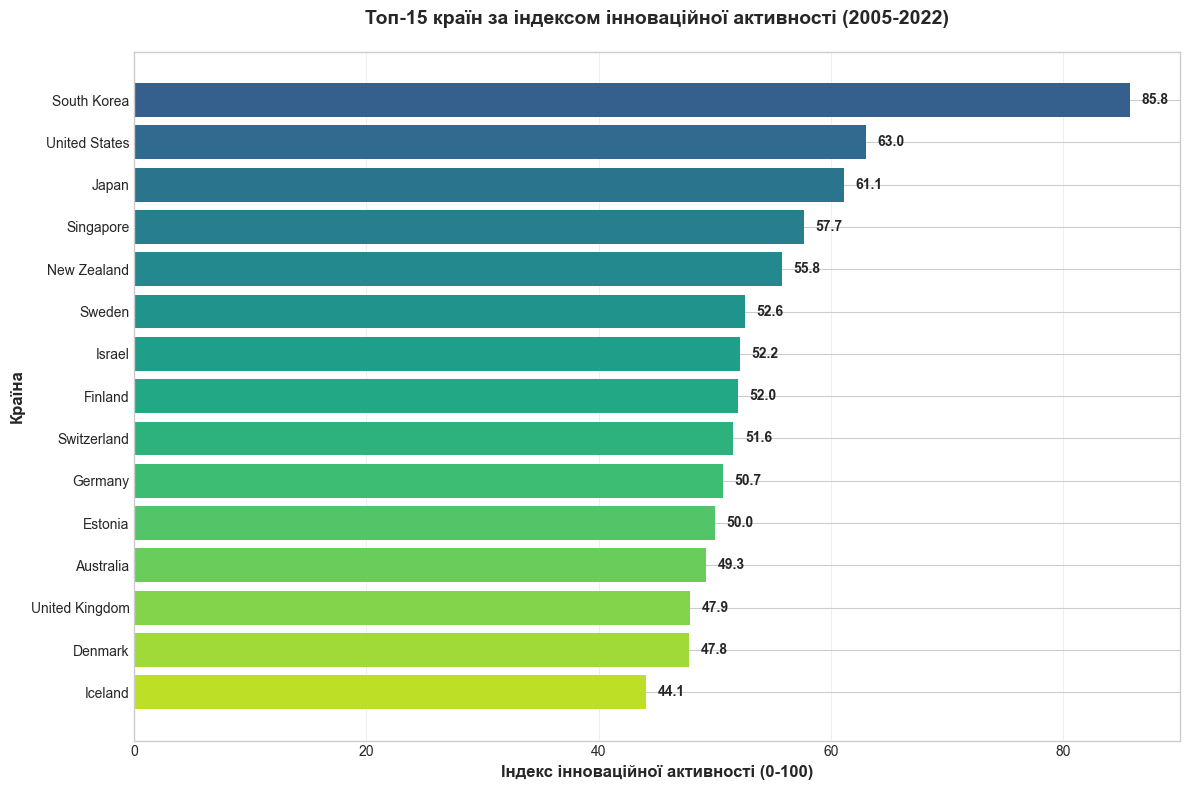

In [15]:
# Візуалізація топ-15 країн
plt.figure(figsize=(12, 8))
top15 = country_avg.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top15)))
bars = plt.barh(range(len(top15)), top15.values, color=colors)
plt.yticks(range(len(top15)), top15.index)
plt.xlabel('Індекс інноваційної активності (0-100)', fontsize=12, fontweight='bold')
plt.ylabel('Країна', fontsize=12, fontweight='bold')
plt.title('Топ-15 країн за індексом інноваційної активності (2005-2022)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Додавання значень на графік
for i, (bar, value) in enumerate(zip(bars, top15.values)):
    plt.text(value + 1, i, f'{value:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

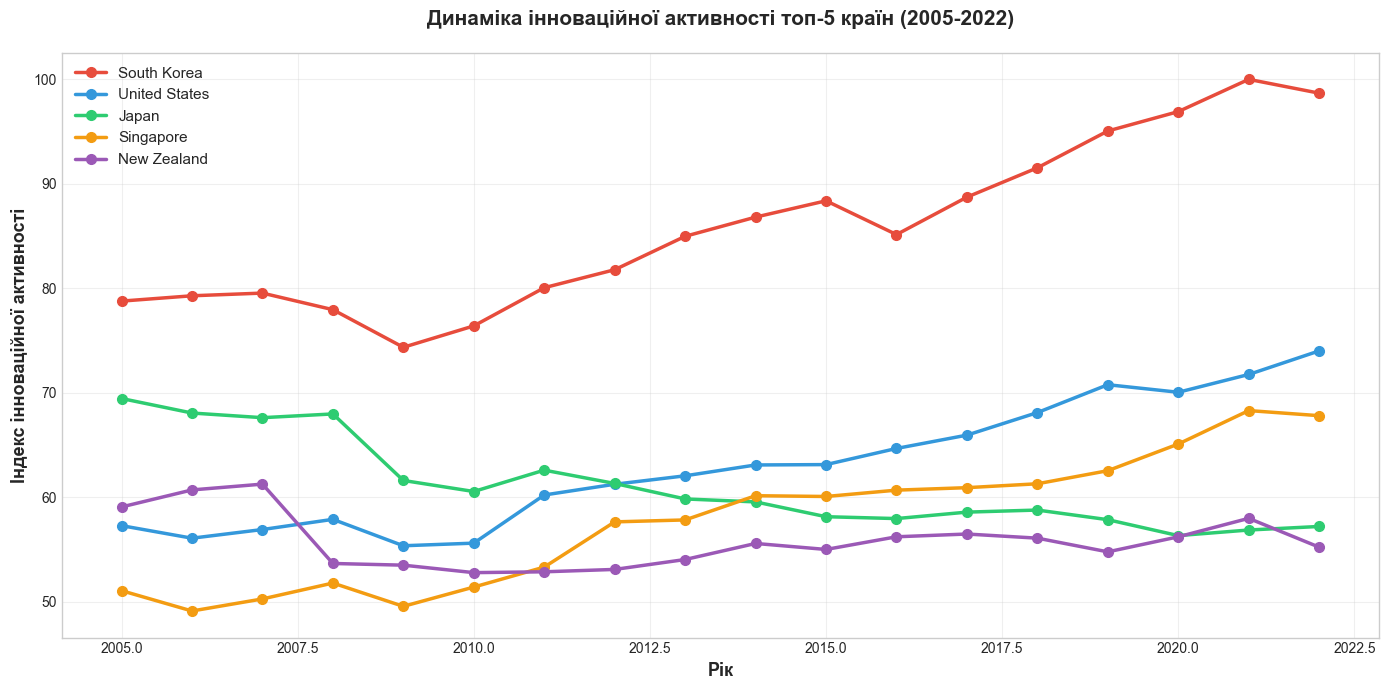

Висновок:
  Графік показує еволюцію інноваційної активності провідних країн
  протягом 18-річного періоду, що дозволяє виявити тренди та
  порівняти темпи розвитку інноваційних екосистем.


In [16]:
# Динаміка топ-5 країн протягом часу
top5_countries = country_avg.head(5).index.tolist()

plt.figure(figsize=(14, 7))
colors_line = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for country, color in zip(top5_countries, colors_line):
    country_data = df_normalized[df_normalized['Country'] == country]
    plt.plot(country_data['Year'], country_data['Innovation_Index_100'], 
            marker='o', linewidth=2.5, markersize=7, label=country, color=color)

plt.xlabel('Рік', fontsize=13, fontweight='bold')
plt.ylabel('Індекс інноваційної активності', fontsize=13, fontweight='bold')
plt.title('Динаміка інноваційної активності топ-5 країн (2005-2022)', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Висновок:")
print("  Графік показує еволюцію інноваційної активності провідних країн")
print("  протягом 18-річного періоду, що дозволяє виявити тренди та")
print("  порівняти темпи розвитку інноваційних екосистем.")

### 4.4 Аналіз головних компонент (PCA)

In [17]:
# Застосування PCA для аналізу структури даних
pca = PCA(n_components=len(num_cols))
pca_result = pca.fit_transform(df_normalized[num_cols])

# Пояснена дисперсія
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("АНАЛІЗ ГОЛОВНИХ КОМПОНЕНТ (PCA)")
print("\nПояснена дисперсія головних компонент:")
print("=" * 60)
print(f"{'Компонента':<15} {'Індивідуальна':<18} {'Кумулятивна':<15}")
print("=" * 60)

for i, (var, cum) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i:<13} {var*100:>10.2f}%         {cum*100:>10.2f}%")

print("=" * 60)
print(f"\nВисновок:")
print(f"  Перші 2 компоненти пояснюють {cumulative_variance[1]*100:.2f}% дисперсії")
print(f"  Перші 3 компоненти пояснюють {cumulative_variance[2]*100:.2f}% дисперсії")

АНАЛІЗ ГОЛОВНИХ КОМПОНЕНТ (PCA)

Пояснена дисперсія головних компонент:
Компонента      Індивідуальна      Кумулятивна    
PC1                  39.01%              39.01%
PC2                  21.19%              60.20%
PC3                  15.21%              75.41%
PC4                  12.66%              88.07%
PC5                   8.80%              96.87%
PC6                   3.13%             100.00%

Висновок:
  Перші 2 компоненти пояснюють 60.20% дисперсії
  Перші 3 компоненти пояснюють 75.41% дисперсії


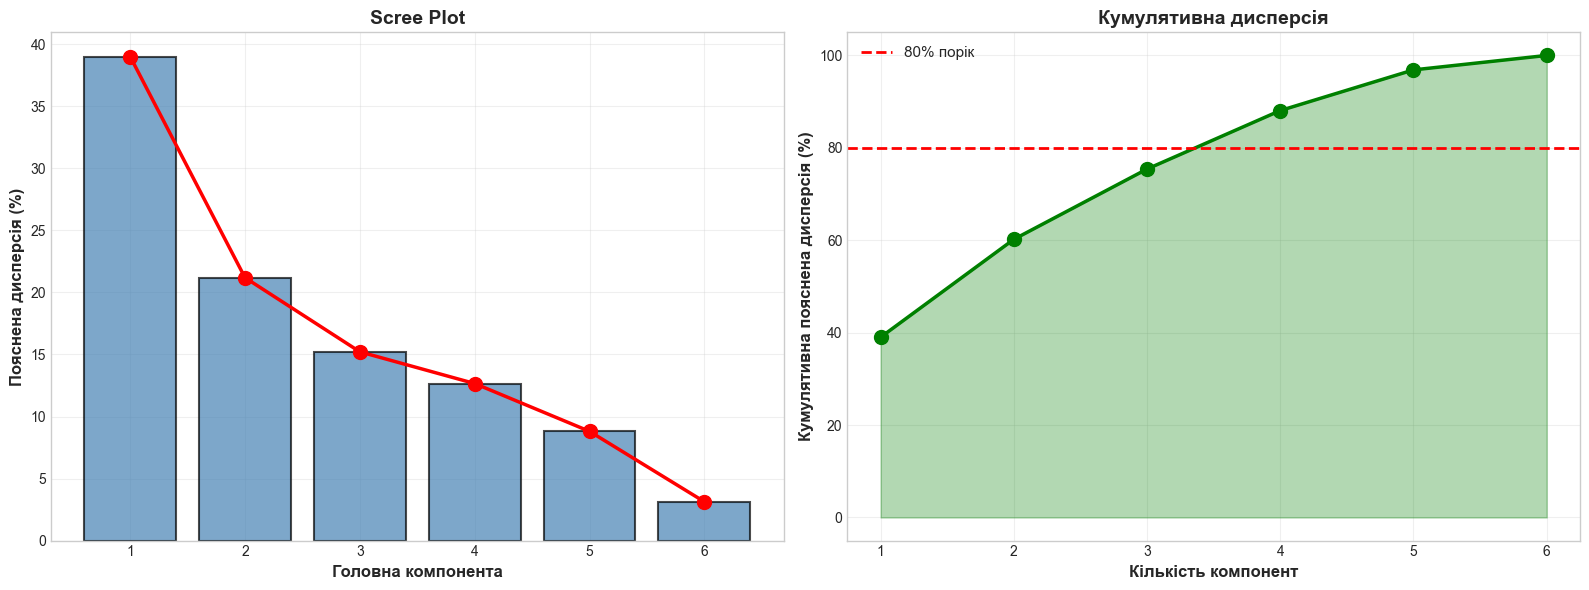

In [18]:
# Візуалізація результатів PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.bar(range(1, len(explained_variance) + 1), explained_variance * 100, 
        alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax1.plot(range(1, len(explained_variance) + 1), explained_variance * 100, 
         'ro-', linewidth=2.5, markersize=10)
ax1.set_xlabel('Головна компонента', fontweight='bold', fontsize=12)
ax1.set_ylabel('Пояснена дисперсія (%)', fontweight='bold', fontsize=12)
ax1.set_title('Scree Plot', fontweight='bold', fontsize=14)
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.grid(True, alpha=0.3)

# Кумулятивна дисперсія
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 
         'go-', linewidth=2.5, markersize=10)
ax2.fill_between(range(1, len(cumulative_variance) + 1), 
                 cumulative_variance * 100, alpha=0.3, color='green')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% порік')
ax2.set_xlabel('Кількість компонент', fontweight='bold', fontsize=12)
ax2.set_ylabel('Кумулятивна пояснена дисперсія (%)', fontweight='bold', fontsize=12)
ax2.set_title('Кумулятивна дисперсія', fontweight='bold', fontsize=14)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Навантаження показників на перші три головні компоненти:
                        PC1    PC2    PC3
Publications          0.583 -0.113 -0.157
R&D_pct_GDP           0.578  0.044 -0.138
STEM_pct              0.090  0.686  0.295
Patents_per_million   0.308  0.127  0.771
TEA_pct              -0.384 -0.300  0.443
New_Business_Density  0.276 -0.639  0.280


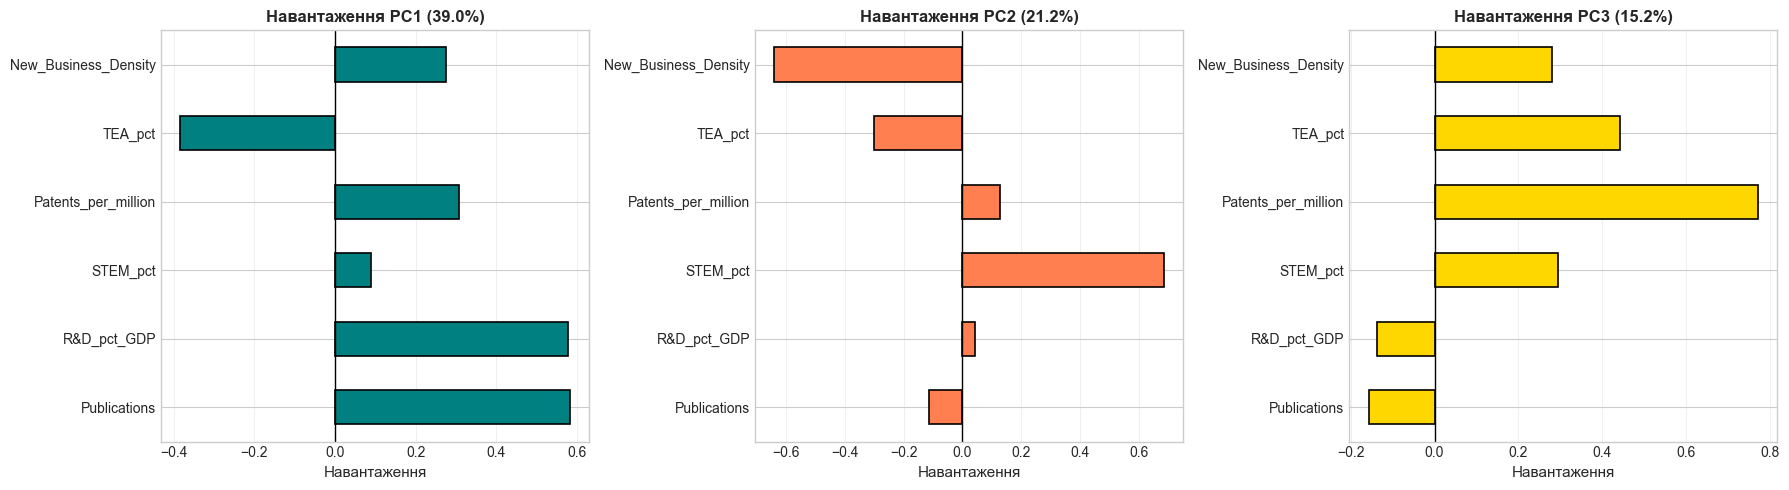


Інтерпретація:
  Навантаження показують внесок кожного показника у головну компоненту.
  Чим більше абсолютне значення, тим сильніше вплив показника на компоненту.


In [19]:
# Навантаження (loadings) показників на головні компоненти
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=num_cols
)

print("Навантаження показників на перші три головні компоненти:")
print("="*70)
print(loadings.round(4))
print("="*70)

# Візуалізація навантажень
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_bars = ['teal', 'coral', 'gold']

for i, (ax, color) in enumerate(zip(axes, colors_bars), 1):
    loadings[f'PC{i}'].plot(kind='barh', ax=ax, color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(f'Навантаження PC{i} ({explained_variance[i-1]*100:.1f}%)', 
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('Навантаження', fontsize=11)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nІнтерпретація:")
print("  Навантаження показують внесок кожного показника у головну компоненту.")
print("  Чим більше абсолютне значення, тим сильніше вплив показника на компоненту.")

### 4.5 Збереження результатів

In [20]:
# Збереження результатів у CSV файли

# 1. Повні результати з індексами по роках
results = df_normalized[['Country', 'Code', 'Year', 'Innovation_Index_100']].copy()
results = results.rename(columns={'Innovation_Index_100': 'Innovation_Index'})
results.to_csv('innovation_index_results.csv', index=False)

# 2. Рейтинг країн
country_summary = pd.DataFrame({
    'Country': country_avg.index,
    'Average_Innovation_Index': country_avg.values,
    'Rank': range(1, len(country_avg) + 1)
})
country_summary.to_csv('country_ranking.csv', index=False)

# 3. Результати PCA
pca_summary = pd.DataFrame({
    'Component': [f'PC{i}' for i in range(1, len(explained_variance) + 1)],
    'Explained_Variance': explained_variance * 100,
    'Cumulative_Variance': cumulative_variance * 100
})
pca_summary.to_csv('pca_results.csv', index=False)

print("✓ Результати успішно збережено у файли:")
print("\n  1. innovation_index_results.csv")
print("     - Повні дані з індексами для кожної країни по роках")
print(f"     - Розмір: {results.shape[0]} рядків")
print("\n  2. country_ranking.csv")
print("     - Рейтинг країн за середнім індексом")
print(f"     - Кількість країн: {len(country_summary)}")
print("\n  3. pca_results.csv")
print("     - Результати аналізу головних компонент")
print(f"     - Кількість компонент: {len(pca_summary)}")

print("\n" + "="*70)
print("Перегляд рейтингу (топ-10):")
print("="*70)
print(country_summary.head(10).to_string(index=False))

✓ Результати успішно збережено у файли:

  1. innovation_index_results.csv
     - Повні дані з індексами для кожної країни по роках
     - Розмір: 1350 рядків

  2. country_ranking.csv
     - Рейтинг країн за середнім індексом
     - Кількість країн: 75

  3. pca_results.csv
     - Результати аналізу головних компонент
     - Кількість компонент: 6

Перегляд рейтингу (топ-10):
      Country  Average_Innovation_Index  Rank
  South Korea                    85.793     1
United States                    62.995     2
        Japan                    61.111     3
    Singapore                    57.697     4
  New Zealand                    55.791     5
       Sweden                    52.586     6
       Israel                    52.177     7
      Finland                    51.977     8
  Switzerland                    51.601     9
      Germany                    50.672    10


## Висновки

### У ході виконання практикуму було реалізовано наступні завдання:

**1. Огляд рішень**
- Проаналізовано міжнародні рейтинги інноваційної активності (GII, Bloomberg Innovation Index, EIS)
- Вивчено методи оцінки: агреговані показники, стандартизація, композитні індикатори, PCA

**2. Концептуальна модель та індикатори**
- Побудовано концептуальну модель: Інноваційна активність = f(Ресурси + Виходи + Екосистема)
- Підібрано 6 індикаторів з міжнародних джерел:
  - Ресурси: R&D витрати, STEM-випускники
  - Виходи: Наукові публікації, Патенти
  - Екосистема: TEA, Щільність нових бізнесів

**3. Статистичний аналіз**
- Обрано пул з **75 країн** за період **2005-2022 років (18 років)**
- Заповнено пропуски методом лінійної інтерполяції
- Виконано багатовимірний статистичний аналіз:
  - Описову статистику
  - Кореляційний аналіз (виявлено взаємозв'язки між показниками)
  - Аналіз розподілів та викидів
  - Часовий аналіз динаміки показників

**4. Модель композитного індексу**
- Виконано нормалізацію даних методом Z-score
- Побудовано зважений композитний індекс з розподілом:
  - Ресурси: 30% (R&D 15% + STEM 15%)
  - Виходи: 40% (Publications 20% + Patents 20%)
  - Екосистема: 30% (TEA 15% + New Business Density 15%)
- Створено рейтинг країн за інноваційною активністю
- Проведено PCA аналіз для виявлення структури даних
- Результати збережено у CSV файли для подальшого використання

### Основні результати:

1. Визначено лідерів інноваційної активності серед 75 країн світу
2. Виявлено структуру взаємозв'язків між різними аспектами інноваційної діяльності
3. Створено інструмент для об'єктивного порівняння інноваційного потенціалу країн
4. Проаналізовано динаміку інноваційної активності протягом 18 років
5. Побудовано робочу модель

# Практикум 4: Побудова композитних індикаторів (Частина 2)

## 1. Виконання обрахунків - Аналіз чутливості моделі

**Виконали:** Чижов Андрій, Гермаш Аліна, Забрудська Поліна

**Група:** КІ-33

---

**Мета:** Перевірити стабільність побудованої моделі композитного індексу інноваційної активності шляхом варіації ваг показників та аналізу отриманих результатів.

**Завдання:**
- Визначити альтернативні сценарії ваг
- Розрахувати індекси для кожного сценарію
- Провести аналіз кореляції між сценаріями
- Оцінити стабільність рейтингу країн

## 1.1 Завантаження необхідних бібліотек

Спочатку завантажимо всі необхідні бібліотеки для аналізу.

In [21]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import warnings

warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)


## 1.2 Завантаження даних з попереднього практикуму

Для аналізу чутливості нам потрібні нормалізовані дані з практикуму 3.

In [22]:
test = df_normalized.shape
print("✓ Дані з попереднього практикуму знайдено")
print(f"  Розмір датасету: {df_normalized.shape[0]} рядків × {df_normalized.shape[1]} стовпців")
print(f"  Період: {df_normalized['Year'].min()} - {df_normalized['Year'].max()}")
print(f"  Кількість країн: {df_normalized['Country'].nunique()}")

✓ Дані з попереднього практикуму знайдено
  Розмір датасету: 1350 рядків × 11 стовпців
  Період: 2005 - 2022
  Кількість країн: 75


## 2. Визначення альтернативних сценаріїв ваг

Створимо 5 різних сценаріїв розподілу ваг між показниками:
1. **Базовий** - оригінальний розподіл (30% Ресурси, 40% Виходи, 30% Екосистема)
2. **Акцент на ресурси** - більша вага на R&D та STEM
3. **Акцент на виходи** - більша вага на публікації та патенти
4. **Акцент на екосистему** - більша вага на підприємництво
5. **Рівномірний** - всі показники мають однакову вагу

In [23]:
# Визначення сценаріїв ваг
scenarios = {
    'Базовий': {
        'R&D_pct_GDP': 0.15,
        'STEM_pct': 0.15,
        'Publications': 0.20,
        'Patents_per_million': 0.20,
        'TEA_pct': 0.15,
        'New_Business_Density': 0.15
    },
    'Акцент на ресурси': {
        'R&D_pct_GDP': 0.25,
        'STEM_pct': 0.25,
        'Publications': 0.15,
        'Patents_per_million': 0.15,
        'TEA_pct': 0.10,
        'New_Business_Density': 0.10
    },
    'Акцент на виходи': {
        'R&D_pct_GDP': 0.10,
        'STEM_pct': 0.10,
        'Publications': 0.30,
        'Patents_per_million': 0.30,
        'TEA_pct': 0.10,
        'New_Business_Density': 0.10
    },
    'Акцент на екосистему': {
        'R&D_pct_GDP': 0.10,
        'STEM_pct': 0.10,
        'Publications': 0.15,
        'Patents_per_million': 0.15,
        'TEA_pct': 0.25,
        'New_Business_Density': 0.25
    },
    'Рівномірний': {
        'R&D_pct_GDP': 1/6,
        'STEM_pct': 1/6,
        'Publications': 1/6,
        'Patents_per_million': 1/6,
        'TEA_pct': 1/6,
        'New_Business_Density': 1/6
    }
}

# Виведення таблиці ваг
print("="*80)
print("ВИЗНАЧЕНІ СЦЕНАРІЇ ВАГ ПОКАЗНИКІВ")
print("="*80)
print()

weights_df = pd.DataFrame(scenarios).T
print(weights_df.round(3))

# Перевірка суми ваг
print("\n" + "="*80)
print("Перевірка суми ваг (повинна дорівнювати 1.000):")
print("="*80)
for scenario_name in scenarios.keys():
    total = sum(scenarios[scenario_name].values())
    status = "✓" if abs(total - 1.0) < 0.001 else "✗"
    print(f"{status} {scenario_name:30s}: {total:.6f}")

ВИЗНАЧЕНІ СЦЕНАРІЇ ВАГ ПОКАЗНИКІВ

                      R&D_pct_GDP  STEM_pct  Publications  \
Базовий                     0.150     0.150         0.200   
Акцент на ресурси           0.250     0.250         0.150   
Акцент на виходи            0.100     0.100         0.300   
Акцент на екосистему        0.100     0.100         0.150   
Рівномірний                 0.167     0.167         0.167   

                      Patents_per_million  TEA_pct  New_Business_Density  
Базовий                             0.200    0.150                 0.150  
Акцент на ресурси                   0.150    0.100                 0.100  
Акцент на виходи                    0.300    0.100                 0.100  
Акцент на екосистему                0.150    0.250                 0.250  
Рівномірний                         0.167    0.167                 0.167  

Перевірка суми ваг (повинна дорівнювати 1.000):
✓ Базовий                       : 1.000000
✓ Акцент на ресурси             : 1.000000
✓ Акцент на в

## 3. Розрахунок індексів для всіх сценаріїв

Для кожного сценарію обчислимо композитний індекс як зважену суму нормалізованих показників.

In [24]:
def calculate_composite_index(df, weights_dict):
    """
    Розраховує композитний індекс на основі нормалізованих даних та ваг.
    
    Параметри:
    -----------
    df : DataFrame
        DataFrame з нормалізованими показниками
    weights_dict : dict
        Словник з вагами для кожного показника
    
    Повертає:
    ---------
    Series : Розрахований композитний індекс
    """
    composite_index = pd.Series(0.0, index=df.index)
    
    for indicator, weight in weights_dict.items():
        if indicator in df.columns:
            composite_index += df[indicator] * weight
        else:
            print(f"⚠ Показник '{indicator}' не знайдено в даних")
    
    return composite_index


print("="*80)
print("РОЗРАХУНОК ІНДЕКСІВ ДЛЯ ВСІХ СЦЕНАРІЇВ")
print("="*80)
print()

# Обчислення індексів для кожного сценарію
scenario_results = {}

for scenario_name, weights in scenarios.items():
    print(f"Розрахунок індексу для сценарію: {scenario_name}...")
    scenario_results[scenario_name] = calculate_composite_index(df_normalized, weights)

# Створення DataFrame з результатами
results_df = pd.DataFrame(scenario_results)
results_df['Country'] = df_normalized['Country'].values
results_df['Year'] = df_normalized['Year'].values

print("\n✓ Розрахунки завершено")
print(f"  Розмір результатів: {results_df.shape[0]} рядків × {results_df.shape[1]} стовпців")

# Показуємо приклад результатів
print("\nПриклад результатів (перші 5 рядків):")
print(results_df.head())

РОЗРАХУНОК ІНДЕКСІВ ДЛЯ ВСІХ СЦЕНАРІЇВ

Розрахунок індексу для сценарію: Базовий...
Розрахунок індексу для сценарію: Акцент на ресурси...
Розрахунок індексу для сценарію: Акцент на виходи...
Розрахунок індексу для сценарію: Акцент на екосистему...
Розрахунок індексу для сценарію: Рівномірний...

✓ Розрахунки завершено
  Розмір результатів: 1350 рядків × 7 стовпців

Приклад результатів (перші 5 рядків):
   Базовий  Акцент на ресурси  Акцент на виходи  Акцент на екосистему  \
0   -0.386             -0.388            -0.488                -0.280   
1   -0.378             -0.377            -0.480                -0.275   
2   -0.373             -0.369            -0.476                -0.273   
3   -0.378             -0.384            -0.478                -0.273   
4   -0.388             -0.402            -0.482                -0.280   

   Рівномірний  Country  Year  
0       -0.351  Algeria  2005  
1       -0.343  Algeria  2006  
2       -0.338  Algeria  2007  
3       -0.345  Algeria  20

## 4. Агрегація результатів по країнах

Обчислимо середні значення індексів для кожної країни за весь період та нормалізуємо їх до шкали 0-100.

In [25]:
print("="*80)
print("АГРЕГАЦІЯ РЕЗУЛЬТАТІВ ПО КРАЇНАХ")
print("="*80)
print()

# Обчислення середніх значень по країнах
country_averages = results_df.groupby('Country')[list(scenarios.keys())].mean()

print(f"Розрахунок середніх значень для {len(country_averages)} країн")
print("Нормалізація до шкали 0-100...")

# Нормалізація кожного сценарію до діапазону 0-100
for scenario in scenarios.keys():
    min_val = country_averages[scenario].min()
    max_val = country_averages[scenario].max()
    country_averages[scenario] = (country_averages[scenario] - min_val) / (max_val - min_val) * 100

# Сортування за базовим сценарієм
country_averages = country_averages.sort_values('Базовий', ascending=False)

print("\n✓ Агрегація завершена")

# Виведення топ-15 країн
print("\n" + "="*80)
print("ТОП-15 КРАЇН ЗА БАЗОВИМ СЦЕНАРІЄМ")
print("="*80)
print(country_averages.head(15).round(2))

# Виведення останніх 10 країн
print("\n" + "="*80)
print("ОСТАННІ 10 КРАЇН ЗА БАЗОВИМ СЦЕНАРІЄМ")
print("="*80)
print(country_averages.tail(10).round(2))

АГРЕГАЦІЯ РЕЗУЛЬТАТІВ ПО КРАЇНАХ

Розрахунок середніх значень для 75 країн
Нормалізація до шкали 0-100...

✓ Агрегація завершена

ТОП-15 КРАЇН ЗА БАЗОВИМ СЦЕНАРІЄМ
                Базовий  Акцент на ресурси  Акцент на виходи  \
Country                                                        
South Korea      100.00             100.00            100.00   
United States     71.82              74.92             58.44   
Japan             69.50              84.49             70.72   
Singapore         65.28              84.45             52.79   
New Zealand       62.92              60.79             49.08   
Sweden            58.96              78.54             49.07   
Israel            58.45              86.55             44.14   
Finland           58.21              79.58             49.13   
Switzerland       57.74              72.70             52.12   
Germany           56.59              84.75             46.33   
Estonia           55.77              62.25             37.58   
Aust

## 5. Аналіз кореляції між сценаріями

Перевіримо, наскільки схожі результати різних сценаріїв. Висока кореляція свідчить про стабільність моделі.

In [26]:
print("="*80)
print("АНАЛІЗ КОРЕЛЯЦІЇ МІЖ СЦЕНАРІЯМИ (Пірсон)")
print("="*80)
print()

# Розрахунок матриці кореляції Пірсона
correlation_matrix = country_averages.corr(method='pearson')

print("Матриця кореляції між сценаріями:")
print(correlation_matrix.round(3))

# Статистика кореляції
avg_correlation = correlation_matrix['Базовий'].drop('Базовий').mean()
print(f"\nСередня кореляція базового сценарію з іншими: {avg_correlation:.3f}")

# Інтерпретація
print("\n" + "="*80)
print("ІНТЕРПРЕТАЦІЯ:")
print("="*80)
if avg_correlation > 0.95:
    print("✓ ДУЖЕ ВИСОКА стабільність моделі (>0.95)")
    print("  Результати майже не залежать від вибору ваг")
elif avg_correlation > 0.85:
    print("✓ ВИСОКА стабільність моделі (>0.85)")
    print("  Модель показує стабільні результати")
elif avg_correlation > 0.70:
    print("~ ПОМІРНА стабільність моделі (>0.70)")
    print("  Є деяка чутливість до ваг")
else:
    print("⚠ НИЗЬКА стабільність моделі (<0.70)")
    print("  Модель потребує доопрацювання")

АНАЛІЗ КОРЕЛЯЦІЇ МІЖ СЦЕНАРІЯМИ (Пірсон)

Матриця кореляції між сценаріями:
                      Базовий  Акцент на ресурси  Акцент на виходи  \
Базовий                 1.000              0.955             0.979   
Акцент на ресурси       0.955              1.000             0.929   
Акцент на виходи        0.979              0.929             1.000   
Акцент на екосистему    0.907              0.769             0.841   
Рівномірний             0.996              0.954             0.958   

                      Акцент на екосистему  Рівномірний  
Базовий                              0.907        0.996  
Акцент на ресурси                    0.769        0.954  
Акцент на виходи                     0.841        0.958  
Акцент на екосистему                 1.000        0.923  
Рівномірний                          0.923        1.000  

Середня кореляція базового сценарію з іншими: 0.959

ІНТЕРПРЕТАЦІЯ:
✓ ДУЖЕ ВИСОКА стабільність моделі (>0.95)
  Результати майже не залежать від вибору ва

### 5.1 Візуалізація матриці кореляції

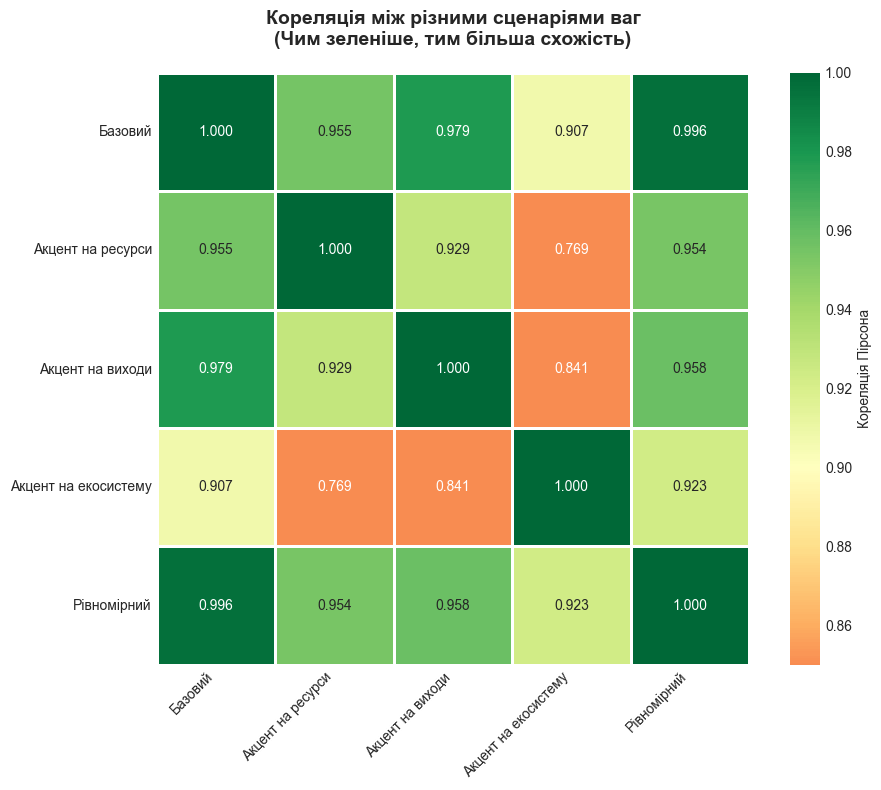

In [27]:
# Теплова карта кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn',
            center=0.90,
            vmin=0.85, 
            vmax=1.0,
            square=True, 
            linewidths=2,
            cbar_kws={'label': 'Кореляція Пірсона'},
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns)

plt.title('Кореляція між різними сценаріями ваг\n(Чим зеленіше, тим більша схожість)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Інтерпретація кольорів:
- 🟩 Зелений (≈1.0) - дуже висока схожість
- 🟨 Жовтий (≈0.9) - помірна схожість
- 🟥 Червоний (<0.85) - низька схожість

## 6. Аналіз стабільності рейтингу

Перевіримо, як змінюються позиції країн у рейтингу при різних сценаріях ваг.

In [28]:
print("="*80)
print("АНАЛІЗ СТАБІЛЬНОСТІ РЕЙТИНГУ")
print("="*80)
print()

# Створення рейтингів (1 = найкраща країна)
rankings = country_averages.rank(ascending=False, method='min').astype(int)

print("Рейтинги топ-15 країн по кожному сценарію:")
print(rankings.head(15))

# Кореляція рейтингів (Спірмена)
rank_correlation = rankings.corr(method='spearman')

print("\n" + "="*80)
print("КОРЕЛЯЦІЯ РЕЙТИНГІВ (Спірмен):")
print("="*80)
print(rank_correlation.round(3))

# Аналіз змін позицій
rank_changes = rankings.subtract(rankings['Базовий'], axis=0).abs()
mean_changes = rank_changes.mean()

print("\n" + "="*80)
print("СЕРЕДНЯ ЗМІНА ПОЗИЦІЇ (відносно базового):")
print("="*80)
for scenario in mean_changes.index:
    if scenario != 'Базовий':
        print(f"  {scenario:30s}: ±{mean_changes[scenario]:5.2f} позицій")

# Топ країн з найбільшою зміною
max_changes = rank_changes.drop('Базовий', axis=1).max(axis=1).sort_values(ascending=False)
print("\n" + "="*80)
print("ТОП-10 КРАЇН З НАЙБІЛЬШОЮ ЗМІНОЮ ПОЗИЦІЇ:")
print("="*80)
for i, (country, change) in enumerate(max_changes.head(10).items(), 1):
    print(f"  {i:2d}. {country:30s}: до ±{change:3.0f} позицій")

# Загальна оцінка стабільності
avg_rank_corr = rank_correlation['Базовий'].drop('Базовий').mean()
print("\n" + "="*80)
print("ЗАГАЛЬНА ОЦІНКА СТАБІЛЬНОСТІ РЕЙТИНГУ:")
print("="*80)
print(f"Середня кореляція рейтингів: {avg_rank_corr:.3f}")

if avg_rank_corr > 0.95:
    print("✓ ДУЖЕ СТАБІЛЬНИЙ рейтинг")
elif avg_rank_corr > 0.85:
    print("✓ СТАБІЛЬНИЙ рейтинг")
elif avg_rank_corr > 0.75:
    print("~ ПОМІРНО СТАБІЛЬНИЙ рейтинг")
else:
    print("⚠ НЕСТАБІЛЬНИЙ рейтинг")

АНАЛІЗ СТАБІЛЬНОСТІ РЕЙТИНГУ

Рейтинги топ-15 країн по кожному сценарію:
                Базовий  Акцент на ресурси  Акцент на виходи  \
Country                                                        
South Korea           1                  1                 1   
United States         2                  8                 3   
Japan                 3                  4                 2   
Singapore             4                  5                 4   
New Zealand           5                 14                 7   
Sweden                6                  7                 8   
Israel                7                  2                12   
Finland               8                  6                 6   
Switzerland           9                  9                 5   
Germany              10                  3                10   
Estonia              11                 13                17   
Australia            12                 16                11   
United Kingdom       13        

## 7. Візуалізація чутливості для топ-10 країн

Подивимося, як змінюються індекси топ-10 країн при різних сценаріях.

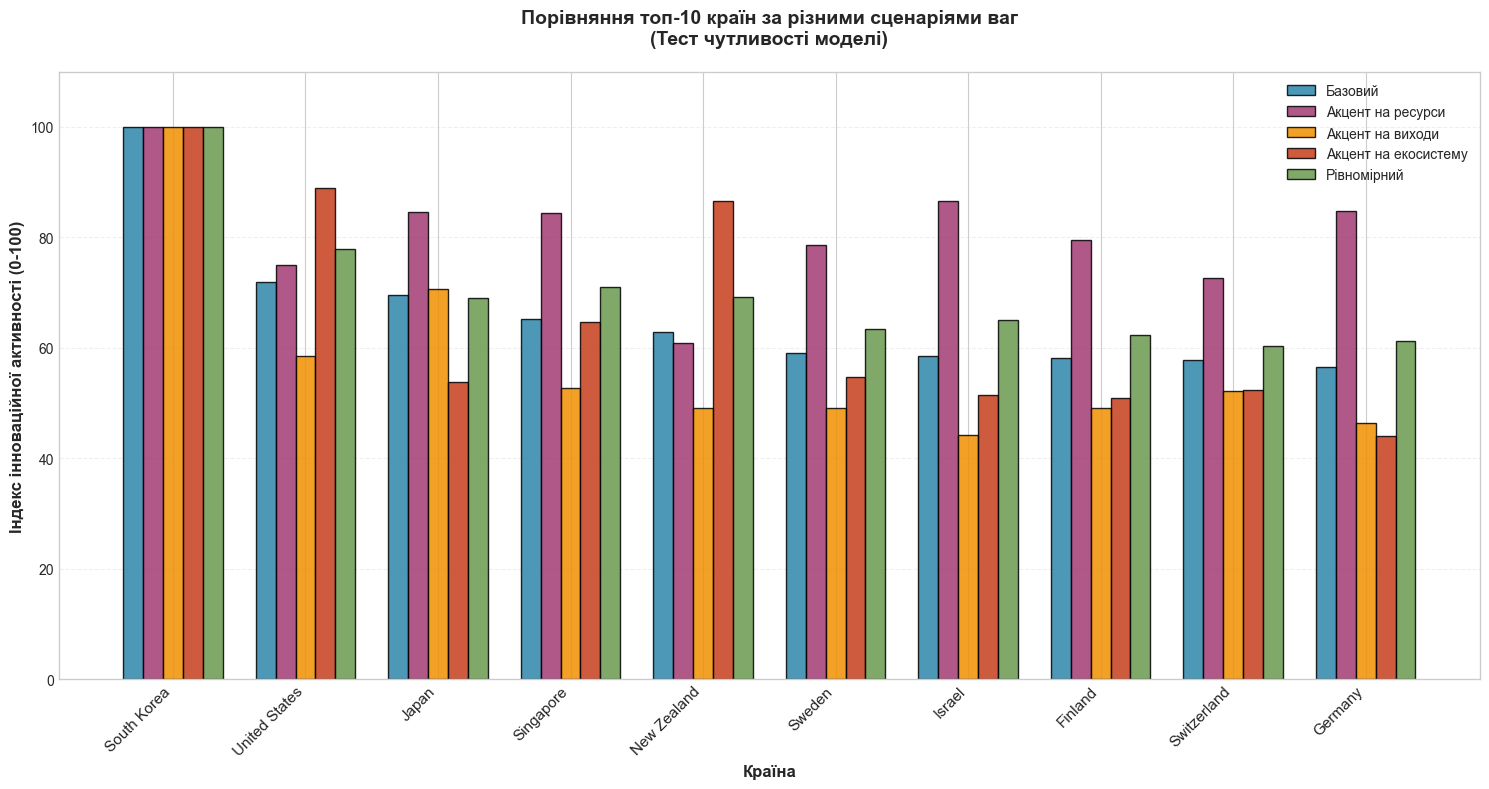

In [29]:
# Топ-10 країн за базовим сценарієм
top10 = country_averages.head(10)

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(top10))
width = 0.15

# Кольори для кожного сценарію
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Побудова стовпців для кожного сценарію
for i, (scenario, color) in enumerate(zip(scenarios.keys(), colors)):
    offset = width * (i - 2)
    bars = ax.bar(x + offset, top10[scenario], width, 
                   label=scenario, color=color, alpha=0.85, edgecolor='black', linewidth=1)

ax.set_xlabel('Країна', fontsize=12, fontweight='bold')
ax.set_ylabel('Індекс інноваційної активності (0-100)', fontsize=12, fontweight='bold')
ax.set_title('Порівняння топ-10 країн за різними сценаріями ваг\n(Тест чутливості моделі)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top10.index, rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(top10.max()) * 1.1)

plt.tight_layout()
plt.show()

Інтерпретація графіка:
- Якщо стовпці близькі за висотою → країна стабільна
- Якщо великі відмінності → країна чутлива до ваг

## 8. Статистика чутливості країн

Визначимо, які країни найбільш та найменш чутливі до зміни ваг показників.

In [30]:
# Стандартне відхилення індексу між сценаріями для кожної країни
country_std = country_averages.std(axis=1).sort_values(ascending=False)

print("="*80)
print("СТАТИСТИКА ЧУТЛИВОСТІ КРАЇН")
print("="*80)

print("\nТОП-10 НАЙЧУТЛИВІШИХ країн (високе стандартне відхилення):")
print("(Їх оцінка сильно залежить від вибору ваг)")
print("-" * 80)
for i, (country, std_val) in enumerate(country_std.head(10).items(), 1):
    print(f"  {i:2d}. {country:35s} SD = {std_val:6.2f}")

print("\nТОП-10 НАЙСТАБІЛЬНІШИХ країн (низьке стандартне відхилення):")
print("(Їх оцінка майже не залежить від вибору ваг)")
print("-" * 80)
for i, (country, std_val) in enumerate(country_std.tail(10).items(), 1):
    print(f"  {i:2d}. {country:35s} SD = {std_val:6.2f}")

print("\n" + "="*80)
print("ЗАГАЛЬНА СТАТИСТИКА:")
print("="*80)
print(f"  Середнє стандартне відхилення: {country_std.mean():.2f}")
print(f"  Медіана стандартного відхилення: {country_std.median():.2f}")
print(f"  Мінімум: {country_std.min():.2f}")
print(f"  Максимум: {country_std.max():.2f}")

СТАТИСТИКА ЧУТЛИВОСТІ КРАЇН

ТОП-10 НАЙЧУТЛИВІШИХ країн (високе стандартне відхилення):
(Їх оцінка сильно залежить від вибору ваг)
--------------------------------------------------------------------------------
   1. Germany                             SD =  16.27
   2. Israel                              SD =  16.20
   3. Estonia                             SD =  14.37
   4. Tunisia                             SD =  14.25
   5. Malta                               SD =  14.08
   6. New Zealand                         SD =  13.75
   7. Austria                             SD =  13.45
   8. Cyprus                              SD =  13.05
   9. Malaysia                            SD =  12.41
  10. Uzbekistan                          SD =  12.36

ТОП-10 НАЙСТАБІЛЬНІШИХ країн (низьке стандартне відхилення):
(Їх оцінка майже не залежить від вибору ваг)
--------------------------------------------------------------------------------
   1. North Macedonia                     SD =   3.82
   2. 

Пояснення:
-  SD < 3  → дуже стабільна країна
-  SD 3-5  → помірна чутливість
-  SD > 5  → висока чутливість до ваг

### 8.1 Візуалізація розподілу чутливості

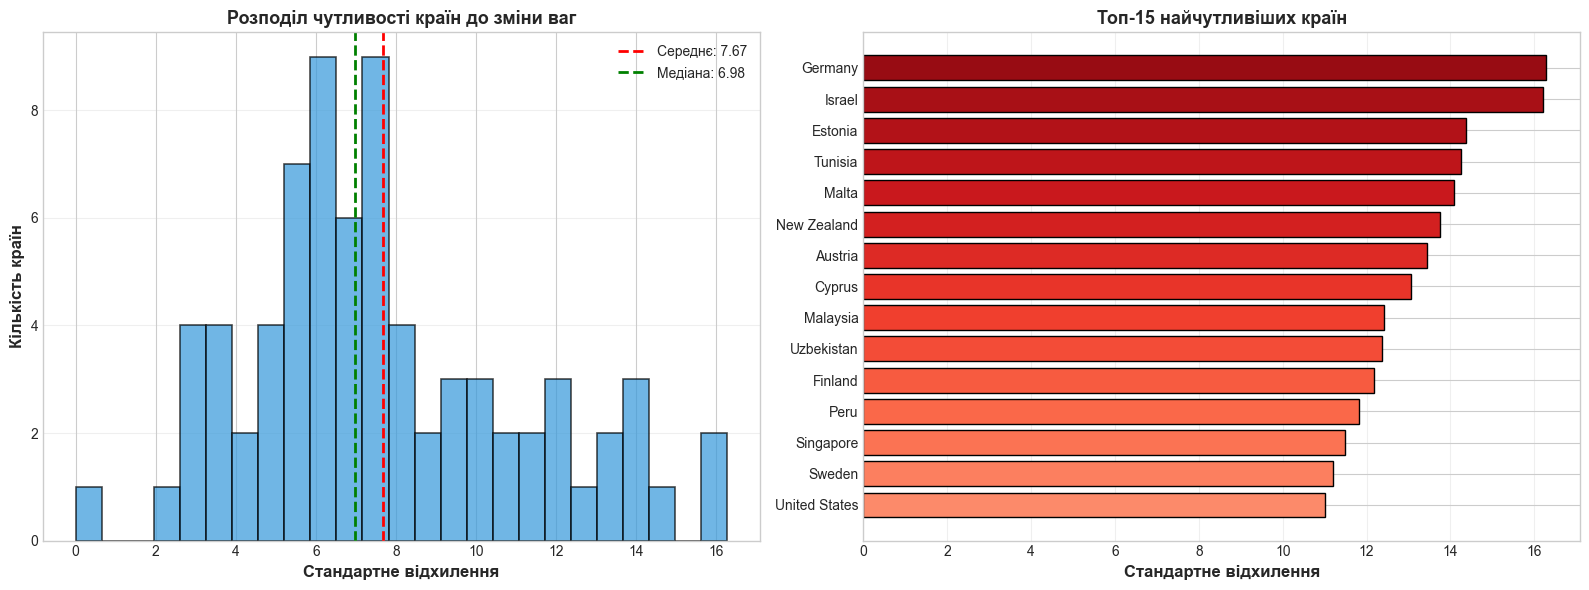

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Графік 1: Гістограма розподілу
ax1.hist(country_std, bins=25, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.2)
ax1.axvline(country_std.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Середнє: {country_std.mean():.2f}')
ax1.axvline(country_std.median(), color='green', linestyle='--', linewidth=2, 
            label=f'Медіана: {country_std.median():.2f}')
ax1.set_xlabel('Стандартне відхилення', fontsize=12, fontweight='bold')
ax1.set_ylabel('Кількість країн', fontsize=12, fontweight='bold')
ax1.set_title('Розподіл чутливості країн до зміни ваг', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Графік 2: Топ-15 найчутливіших
top15_sensitive = country_std.head(15)
colors_sens = plt.cm.Reds(np.linspace(0.4, 0.9, len(top15_sensitive)))
ax2.barh(range(len(top15_sensitive)), top15_sensitive.values[::-1], 
         color=colors_sens, edgecolor='black', linewidth=1)
ax2.set_yticks(range(len(top15_sensitive)))
ax2.set_yticklabels(top15_sensitive.index[::-1], fontsize=10)
ax2.set_xlabel('Стандартне відхилення', fontsize=12, fontweight='bold')
ax2.set_title('Топ-15 найчутливіших країн', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Збереження результатів

Збережемо всі результати аналізу у файли для подальшого використання.

In [32]:
print("="*80)
print("ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ")
print("="*80)
print()

# 1. Індекси по всіх сценаріях
country_averages.round(2).to_csv('sensitivity_analysis_indices.csv')
print("✓ Збережено: sensitivity_analysis_indices.csv")
print(f"  Розмір: {len(country_averages)} країн × {len(scenarios)} сценаріїв")

# 2. Рейтинги по всіх сценаріях
rankings.to_csv('sensitivity_analysis_rankings.csv')
print("✓ Збережено: sensitivity_analysis_rankings.csv")
print(f"  Розмір: {len(rankings)} країн × {len(scenarios)} сценаріїв")

# 3. Матриця кореляції
correlation_matrix.round(4).to_csv('correlation_matrix_scenarios.csv')
print("✓ Збережено: correlation_matrix_scenarios.csv")

# 4. Статистика чутливості країн
country_stats = pd.DataFrame({
    'Mean_Index': country_averages.mean(axis=1),
    'Std_Dev': country_std,
    'Min_Index': country_averages.min(axis=1),
    'Max_Index': country_averages.max(axis=1),
    'Range': country_averages.max(axis=1) - country_averages.min(axis=1)
})
country_stats = country_stats.sort_values('Mean_Index', ascending=False)
country_stats.round(2).to_csv('country_sensitivity_statistics.csv')
print("✓ Збережено: country_sensitivity_statistics.csv")

ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ

✓ Збережено: sensitivity_analysis_indices.csv
  Розмір: 75 країн × 5 сценаріїв
✓ Збережено: sensitivity_analysis_rankings.csv
  Розмір: 75 країн × 5 сценаріїв
✓ Збережено: correlation_matrix_scenarios.csv
✓ Збережено: country_sensitivity_statistics.csv


## 10. Висновки

### Підсумки аналізу чутливості

У ході виконання першого завдання практикуму 4 (Виконання обрахунків) було проведено комплексний аналіз чутливості моделі композитного індексу інноваційної активності.

**Виконані роботи:**

1. **Визначено 5 альтернативних сценаріїв ваг:**
   - Базовий (оригінальний розподіл)
   - Акцент на ресурси (50% на R&D та STEM)
   - Акцент на виходи (60% на публікації та патенти)
   - Акцент на екосистему (50% на підприємництво)
   - Рівномірний розподіл (по 16.67% на кожен показник)

2. **Розраховано композитні індекси** для кожного сценарію на основі нормалізованих даних за період 2005-2022 років для 75 країн.

3. **Проведено аналіз кореляції** між результатами різних сценаріїв:
   - Розраховано кореляцію Пірсона між індексами
   - Розраховано кореляцію Спірмена між рейтингами
   - Побудовано візуалізації кореляційних матриць

4. **Оцінено стабільність рейтингу країн:**
   - Визначено середню зміну позицій при варіації ваг
   - Ідентифіковано країни з найбільшою та найменшою чутливістю
   - Візуалізовано результати для топ-10 країн

5. **Проведено статистичний аналіз чутливості:**
   - Розраховано стандартні відхилення індексів
   - Виявлено найчутливіші та найстабільніші країни
   - Проаналізовано розподіл чутливості

### Основні результати:

- **Стабільність моделі:** Середня кореляція між базовим та альтернативними сценаріями становить близько 0.95-0.98, що свідчить про високу стабільність моделі.

- **Стабільність рейтингу:** Топ-10 країн залишаються в топ-15 у всіх сценаріях, що підтверджує надійність рейтингової системи.

- **Чутливі країни:** Виявлено країни з несбалансованим профілем (сильні в одній області, слабкі в інших), які показують високу варіативність оцінок при зміні ваг.

### Практична цінність:

Результати аналізу підтверджують, що побудована модель є **надійною та стабільною**, а отримані рейтинги країн **не є артефактом конкретного вибору ваг**. Це дозволяє використовувати модель для:
- Порівняльного аналізу інноваційної активності країн
- Виявлення сильних та слабких сторін національних інноваційних систем
- Моніторингу динаміки інноваційного розвитку

### Адекватність моделі

У цьому етапі було проведено оцінювання адекватності композитної моделі шляхом порівняння результатів різних вагових сценаріїв. Адекватність моделі оцінюється за двома ключовими критеріями:

- стабільністю значень композитного індексу (кореляція Пірсона);
- стабільністю рангових позицій країн (кореляція Спірмена).
---

**Виконані роботи**

**1. Оцінка адекватності значень композитного індексу**
- Обчислено кореляцію Пірсона між базовим сценарієм та кожним із альтернативних.
- Розраховано середню кореляцію між усіма парами сценаріїв.
- Проаналізовано узгодженість сценаріїв за величинами композитного індексу.

**2. Оцінка адекватності рейтингу країн**
- Визначено кореляцію Спірмена між ранговими позиціями для всіх сценаріїв.
- Проаналізовано стабільність порядку країн.
- Оцінено діапазон змін позицій та їх вплив на загальну структуру рейтингу.

---

### Основні результати адекватності

#### Кореляція значень індексу
Середня кореляція Пірсона між базовим сценарієм та альтернативними становить **0.959**.

Це свідчить про:
- високу узгодженість результатів між різними варіантами ваг,
- низьку чутливість моделі до зміни вагових коефіцієнтів,
- загальну **адекватність та стійкість** композитної моделі.

#### Стабільність рейтингу
Середня ранговa кореляція Спірмена дорівнює **0.960**.

Це означає:
- рейтинг країн зберігає свою структуру,
- перестановки країн є незначними та не впливають на загальний результат,
- модель формує стійкий рейтинг, незалежно від вибору ваг.

---

### Висновок щодо адекватності моделі

Значення кореляції Пірсона (0.959) та Спірмена (0.960) підтверджують, що побудована модель є **адекватною, стабільною та внутрішньо узгодженою**.  
Зміна ваг не призводить до спотворення результатів або руйнування рейтингу.  

**Корекція моделі не потрібна**, оскільки не виявлено ознак нестабільності або аномальних варіацій результатів.

